<a href="https://colab.research.google.com/github/PierreGroshens/NLP_Project/blob/frederik/Training_and_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Pip installing relevant non-build-in packages
#%%capture
!pip install transformers
!pip install datasets

In [2]:
#Packages
import pandas as pd
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
from transformers import Trainer
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
import seaborn as sns

In [3]:
# Loading and clearning the data for the Huggingface load_dataset function

def load_clean_data(filename = "train_data", # Specify what file you want to edit
                    file_path = "/content/drive/MyDrive/NLP&DL/Exam/", #And the path it is stored
                    saving_path = "/content/drive/MyDrive/NLP&DL/Exam/"): # And the path to store the new datafile
  
  # We read in the data, but only the two columns of interest: text and label
  data = pd.read_csv(f"{file_path}{filename}.csv")[["text", "label"]]  

  # From string to integer
  data["label"] = data.label.replace({'comment': 0, 'deny': 1, 'query': 2, 'support': 3})
  data["label"] = data["label"].fillna(5)

  # Remove missings (if any), 2 obs for training data
  try: 
    data = data.drop(data.index[data.label == 5]) 
  except:
    print(f"{filename} has no missing labels")

  data = data.dropna()

  # Changing the type of the label column to an integer
  data["label"] = data["label"].astype(int)

  # Saving the new datafile without index
  data.to_csv(f"{saving_path}{filename}_cleaned.csv", index = False)

  # Return the path of the new file
  path = saving_path + filename + "_cleaned.csv"
  return path

In [4]:
# Call load_dataset on the three cleaned datasets
RumourEval2019 = load_dataset('csv', data_files={'train': load_clean_data("train_data"),
                                                 'eval' : load_clean_data("eval_data"),
                                                 'test' : load_clean_data("test_data")})

Using custom data configuration default-fad941448c49cfd3


0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-fad941448c49cfd3/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff. Subsequent calls will reuse this data.


In [5]:
# We load a pretrained tokenizer from the distilbert base model
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased")

# Then we define a function that takes our dataset as input, tokenizes the text column,
# and uses padding for tweets with less than 280 characthers (the maximum allowed),
# and truncate tweets longer than this (should not exist)
def tokenize(dataset):
    return tokenizer(dataset["text"], padding= 'max_length', truncation=True)

# We apply the function to all of our dataset using .map()
RumourEval2019_tokenized = RumourEval2019.map(tokenize)

  0%|          | 0/4518 [00:00<?, ?ex/s]

  0%|          | 0/1049 [00:00<?, ?ex/s]

  0%|          | 0/1066 [00:00<?, ?ex/s]

In [6]:
# We extract the training, validation and test datasets from the tokenized object 
training_dataset   = RumourEval2019_tokenized["train"]
validation_dataset = RumourEval2019_tokenized["eval"]
testing_dataset    = RumourEval2019_tokenized["test"]

In [9]:
# We load our pretrained classification model: distilBERT 
distilbert = AutoModelForSequenceClassification.from_pretrained("distilbert-base-cased", num_labels=len(set(training_dataset["label"])))

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifier.b

In [10]:
# We load the training parameter that needs to be tuned in the training of the model
training_args = TrainingArguments("test_trainer")

In [11]:
# Instead of writing the training loop ourselves we use the Huggingface Trainer()
trainer = Trainer(
    model = distilbert, # We want to train the distilbert model
    args = training_args, #The training arguments from above
    train_dataset = training_dataset #We use the training dataset to train...
    )

In [12]:
# We initialize the actual training
trainer.train()

The following columns in the training set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text.
***** Running training *****
  Num examples = 4518
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1695


Step,Training Loss
500,0.892000
1000,0.803800
1500,0.702800


Saving model checkpoint to test_trainer/checkpoint-500
Configuration saved in test_trainer/checkpoint-500/config.json
Model weights saved in test_trainer/checkpoint-500/pytorch_model.bin
Saving model checkpoint to test_trainer/checkpoint-1000
Configuration saved in test_trainer/checkpoint-1000/config.json
Model weights saved in test_trainer/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to test_trainer/checkpoint-1500
Configuration saved in test_trainer/checkpoint-1500/config.json
Model weights saved in test_trainer/checkpoint-1500/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1695, training_loss=0.7810765134198124, metrics={'train_runtime': 706.8767, 'train_samples_per_second': 19.174, 'train_steps_per_second': 2.398, 'total_flos': 1795527160455168.0, 'train_loss': 0.7810765134198124, 'epoch': 3.0})

In [13]:
# We define a class to asses perfomance
class perfomance_metrics():
  def __init__(self, data):
    self.data = data
    self.predictions = trainer.predict(self.data)
    self.predicted_label = np.argmax(self.predictions.predictions, axis=-1)

  def accuracy_func(self):
    counter = 0
    for i in range(len(self.predicted_label)):
      counter += (self.predicted_label[i] == self.data["label"][i])
  
    self.accuracy = counter/len(self.data["label"])
    print(f"Accuracy: {self.accuracy}")

    #return self.accuracy

  def f1_macro_func(self):
    self.f1_macro = f1_score(self.predicted_label, self.data["label"], average="macro")
    print(f"Macro weighted F1-Score: {self.f1_macro}")

    #return self.f1_macro
    
  def cm_func(self):

      cm = confusion_matrix(self.data["label"], self.predicted_label)
      sns.set_style("whitegrid", {'axes.grid' : False})
      plt.rcParams["font.family"] = "Times New Roman"

      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

      fig, ax = plt.subplots()
      im = ax.imshow(cm, cmap = 'Blues')
      ax.figure.colorbar(im, ax=ax)

      plt.xticks([0, 1, 2, 3], labels = ['comment', 'deny', 'query', 'support']) 
      plt.xlabel('Predicted tweet label', fontsize=14,)
      plt.yticks([0, 1, 2, 3], labels = ['comment', 'deny', 'query', 'support']) 
      plt.ylabel('True tweet label', fontsize=14,)
      plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

      thresh = cm.max() / 2.
      for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

      fig.tight_layout()

      return plt.show()

In [14]:
metrics = perfomance_metrics(validation_dataset) # Here we use test data, but should be validation set

The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text.
***** Running Prediction *****
  Num examples = 1066
  Batch size = 8


In [15]:
metrics.accuracy_func()

Accuracy: 0.7664165103189493


In [16]:
metrics.f1_macro_func()

Macro weighted F1-Score: 0.5048751897902264


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


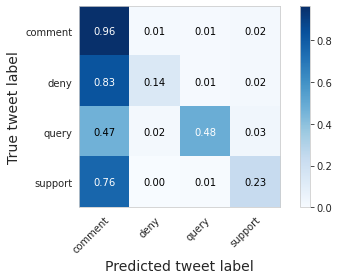

In [17]:
metrics.cm_func()